## Data Preprocessing, common to all approaches

In [14]:
import pandas as pd

df = pd.read_csv('Dataset/selected-crime-data.csv')
print(df.shape)

relevant_crimes = [
    'HARRASSMENT 2', 'CRIMINAL MISCHIEF & RELATED OF', 'PETIT LARCENY',
    'ASSAULT 3 & RELATED OFFENSES', 'ROBBERY', 'VEHICLE AND TRAFFIC LAWS',
    'DANGEROUS DRUGS', 'GRAND LARCENY OF MOTOR VEHICLE', 'GRAND LARCENY',
    'BURGLARY', 'FELONY ASSAULT', 'DANGEROUS WEAPONS', 'CRIMINAL TRESPASS',
    'RAPE', 'SEX CRIMES', 'INTOXICATED & IMPAIRED DRIVING', 'POSSESSION OF STOLEN PROPERTY',
    'DISORDERLY CONDUCT', 'THEFT OF SERVICES', 'MURDER & NON-NEGL. MANSLAUGHTER',
    'HOMICIDE-NEGLIGENT,UNCLASSIFIE', 'KIDNAPPING', 'INTOXICATED/IMPAIRED DRIVING',
    'OFFENSES RELATED TO CHILDREN'
]

df_filtered = df[df['OFNS_DESC'].isin(relevant_crimes)]

df_filtered = df_filtered[df_filtered['LOC_OF_OCCUR_DESC'] != 'INSIDE']

df_sampled = df_filtered.sample(frac=0.2)
print(f"Size of the filtered DataFrame: {df_sampled.shape}")
print(df_sampled.head())

(1048575, 15)
Size of the filtered DataFrame: (88018, 15)
        CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM                       OFNS_DESC  \
286860   270512463   06/28/2023     13:12:00    ASSAULT 3 & RELATED OFFENSES   
101393   276448881   10/25/2023     07:50:00                         ROBBERY   
527264   262108964   01/18/2023     09:45:00  CRIMINAL MISCHIEF & RELATED OF   
860503   246425185   06-09-2022     15:20:00    ASSAULT 3 & RELATED OFFENSES   
1032722  240438529   02-10-2022     17:05:00                   HARRASSMENT 2   

          LAW_CAT_CD    BORO_NM LOC_OF_OCCUR_DESC               PREM_TYP_DESC  \
286860   MISDEMEANOR  MANHATTAN          FRONT OF            RESTAURANT/DINER   
101393        FELONY  MANHATTAN          FRONT OF                      STREET   
527264   MISDEMEANOR     QUEENS            (null)      RESIDENCE - APT. HOUSE   
860503   MISDEMEANOR      BRONX          FRONT OF  RESIDENCE - PUBLIC HOUSING   
1032722    VIOLATION  MANHATTAN          FRONT OF       

In [15]:
import osmnx as ox
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import random
import matplotlib.pyplot as plt

# Load the NYC street network
city = 'New York City, New York, USA'
G = ox.graph_from_place(city, network_type='drive')


## using adaboost to make 3 DTs

In [25]:
## # Load and preprocess crime data
crime_data = df_sampled

# Feature engineering
crime_data['hour'] = pd.to_datetime(crime_data['CMPLNT_FR_TM']).dt.hour
crime_data['category'] = crime_data['OFNS_DESC'].astype('category')
crime_data['is_high_risk'] = crime_data['category'].apply(lambda x: 1 if x in ['KIDNAPPING',
                                                                                     'INTOXICATED/IMPAIRED DRIVING', 
                                                                                     'MURDER & NON-NEGL. MANSLAUGHTER', 
                                                                                     'DANGEROUS DRUGS', 'HARRASSMENT 2'] else 0)

# Aggregate data to create features
risk_features = crime_data.groupby(['hour', 'category']).size().reset_index(name='counts')
risk_features['is_high_risk'] = risk_features['category'].apply(lambda x: 1 if x in [ 'KIDNAPPING',
                                                                                     'INTOXICATED/IMPAIRED DRIVING', 
                                                                                     'MURDER & NON-NEGL. MANSLAUGHTER', 
                                                                                     'DANGEROUS DRUGS', 'HARRASSMENT 2'] else 0)

# Prepare the dataset for training
X = risk_features[['hour', 'counts']]
y = risk_features['is_high_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the AdaBoost model with Decision Trees as base estimators
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Use Decision Trees as the base estimator
base_model = DecisionTreeClassifier(max_depth=5, random_state=42)  # Stumps as weak learners
model = AdaBoostClassifier(base_estimator=base_model, n_estimators=3, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7168674698795181
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       126
           1       0.33      0.17      0.23        40

    accuracy                           0.72       166
   macro avg       0.55      0.53      0.53       166
weighted avg       0.67      0.72      0.68       166



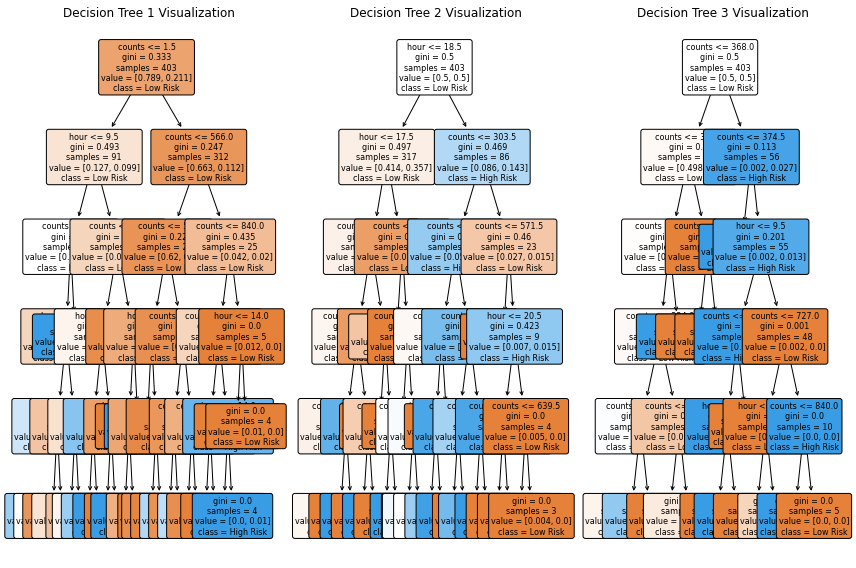

In [10]:
from sklearn.tree import plot_tree

# Visualize the individual trees (optional)
plt.figure(figsize=(12, 8))
for i, tree in enumerate(model.estimators_):
    plt.subplot(1, 3, i + 1)
    plot_tree(tree, filled=True, feature_names=['hour', 'counts'], class_names=['Low Risk', 'High Risk'], rounded=True, fontsize=8)
    plt.title(f'Decision Tree {i+1} Visualization')
plt.tight_layout()
plt.savefig('ada_boost_trees.png')  # Save the trees as an image
plt.show()

In [5]:
import networkx as nx

2
No path found between 42491183 and 1580125492
Route 1 risk score: 0.02
Route 2 risk score: 0.01


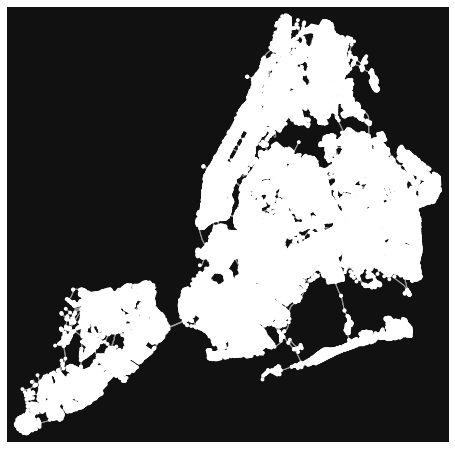

In [11]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Function to get n shortest routes
def get_n_shortest_routes(G, origin, destination, n=4):
    paths = []
    G_temp = G.copy()
    for _ in range(n):
        try:
            path = nx.shortest_path(G_temp, origin, destination, weight='length')
            paths.append(path)
            
            # Remove edges in the current path to find a different path next time
            for i in range(len(path) - 1):
                if G_temp.has_edge(path[i], path[i + 1]):
                    G_temp.remove_edge(path[i], path[i + 1])
        
        except nx.NetworkXNoPath:
            print(len(paths))
            print(f"No path found between {origin} and {destination}")
            break
    
    return paths

# Function to calculate risk score for a route
def calculate_route_risk(route):
    risk_scores = []
    for node in route:
       
        latitude = G.nodes[node]['y']
        longitude = G.nodes[node]['x']
       
        hour = random.randint(0, 23)
        crime_counts = crime_data[(crime_data['hour'] == hour) & (crime_data['Longitude'].between(longitude-0.01, longitude+0.01)) &
                                  (crime_data['Latitude'].between(latitude-0.01, latitude+0.01))]

        if not crime_counts.empty:
            counts = crime_counts.shape[0]
            risk_score = model.predict([[hour, counts]])[0]
            risk_scores.append(risk_score)
        else:
            risk_scores.append(0)  # No crimes, low risk

    return np.mean(risk_scores)  # Average risk score for the route

# Main function to find and evaluate routes
def evaluate_routes():
    # Randomly select origin and destination nodes
    orig_node = random.choice(list(G.nodes))
    dest_node = random.choice(list(G.nodes))

    # Get the routes
    routes = get_n_shortest_routes(G, orig_node, dest_node, n=3)
    
    # Calculate and print risk scores for each route
    for i, route in enumerate(routes):
        risk_score = calculate_route_risk(route)
        print(f"Route {i+1} risk score: {risk_score:.2f}")

    # Plot the routes
    fig, ax = ox.plot_graph(G, show=False, close=False)
    for route in routes:
        route_geom = ox.plot_route_folium(G, route, color='blue', weight=2)
    plt.show()

# Run the evaluation
evaluate_routes()
